# Fine-Tuning Vision Transformers for Image Classification

Just as transformers-based models have revolutionized NLP, we're now seeing an explosion of papers applying them to all sorts of other domains. One of the most revolutionary of these was the Vision Transformer (ViT), which was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain.

This paper explored how you can tokenize images, just as you would tokenize sentences, so that they can be passed to transformer models for training. Its quite a simple concept, really...

1. Split an image into a grid of sub-image patches
1. Embed each patch with a linear projection
1. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)


It turns out that once you've done the above, you can pre-train and finetune transformers just as you're used to with NLP tasks. Pretty sweet 😎.

---

In this notebook, we'll walk through how to leverage 🤗 `datasets` to download and process image classification datasets, and then use them to fine-tune a pre-trained ViT with 🤗 `transformers`. 

To get started, lets first install both those packages.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue Apr  5 07:27:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:17:00.0 Off |                  N/A |
| 43%   52C    P0    76W / 160W |     33MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:65:00.0 Off |                  N/A |
| 53%   

In [1]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers

UsageError: Line magic function `%%capture` not found.


In [2]:
# %%capture
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [3]:
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the [`beans`](https://huggingface.co/datasets/beans) dataset, which is a collection of pictures of healthy and unhealthy bean leaves. 🍃



In [4]:
from datasets import load_dataset
from PIL import Image
ds = load_dataset('gary109/orchid219')
ds

Using custom data configuration gary109--orchid219-f4afad8d7a190c58
Reusing dataset parquet (/root/.cache/huggingface/datasets/parquet/gary109--orchid219-f4afad8d7a190c58/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['filename', 'image', 'labels'],
        num_rows: 219
    })
    train: Dataset({
        features: ['filename', 'image', 'labels'],
        num_rows: 1752
    })
    validation: Dataset({
        features: ['filename', 'image', 'labels'],
        num_rows: 219
    })
})

Let's take a look at the 400th example from the `'train'` split from the beans dataset. You'll notice each example from the dataset has 3 features:

1. `image`: A PIL Image
1. `image_file_path`: The `str` path to the image file that was loaded as `image`
1. `labels`: A [`datasets.ClassLabel`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel) feature, which we'll see as an integer representation of the label for a given example. (Later we'll see how to get the string class names, don't worry)

In [5]:
ex = ds['train'][400]
ex

{'filename': 'xsw9qv0oy5.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x640 at 0x7F1BC50C00D0>,
 'labels': 49}

Let's take a look at the image 👀

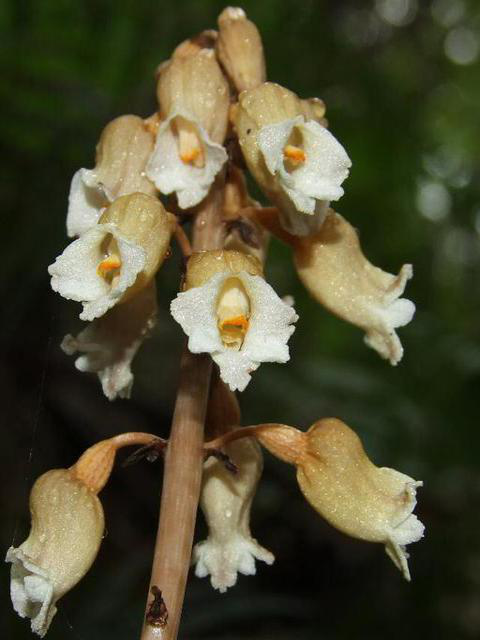

In [6]:
image = ex['image']
image

Thats definitely a leaf! But what kind? 😅

Since the `'labels'` feature of this dataset is a `datasets.features.ClassLabel`, we can use it to lookup the corresponding name for this example's label ID.

First, lets access the feature definition for the `'labels'`.

In [7]:
labels = ds['train'].features['labels']
labels

ClassLabel(num_classes=219, names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

Now, lets print out the class label for our example. We'll do that by using the [`int2str`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) function of `ClassLabel`, which, as the name implies, lets us pass the int representation of the class to look up the string label.

In [8]:
labels.int2str(ex['labels'])

'49'

Turns out the leaf shown above is infected with Bean Rust, a serious disease in bean plants. 😢

Let's write a function that'll display a grid of examples from each class so we can get a better idea of what we're working with.

Loading cached processed dataset at /root/.cache/huggingface/datasets/parquet/gary109--orchid219-f4afad8d7a190c58/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-6e622a78fa157348.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/parquet/gary109--orchid219-f4afad8d7a190c58/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-b6ecabcd82b95104.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/parquet/gary109--orchid219-f4afad8d7a190c58/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-e4c050e2f7ee9981.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/parquet/gary109--orchid219-f4afad8d7a190c58/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-e3d86f79cdd2ffa8.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/parquet/gary109--orchid219-f4afad8d7a190c58/0.0.0/0b6d5799bb726b24ad7fc7be

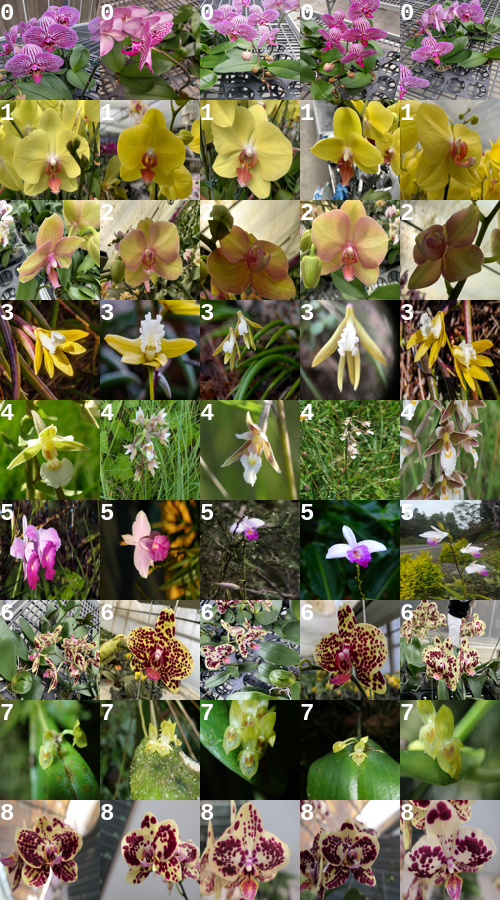

In [9]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(100, 100)):

    w, h = size
    labels = ds['train'].features['labels'].names
    labels = labels[:9]
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("./fonts/LiberationMono-Bold.ttf", 24)
    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, str(label), (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=5)

From what I'm seeing, 
- Angular Leaf Spot: Has irregular brown patches
- Bean Rust:  Has circular brown spots surrounded with a white-ish yellow ring
- Healthy: ...looks healthy. 🤷‍♂️

## Loading ViT Feature Extractor

Now that we know what our images look like and have a better understanding of the problem we're trying to solve, let's see how we can prepare these images for our model. 

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load its feature extractor from the 🤗 Hub.

In [10]:
# from transformers import ViTFeatureExtractor
# from transformers import CLIPFeatureExtractor
# model_name_or_path = "openai/clip-vit-base-patch32"
# feature_extractor = CLIPFeatureExtractor.from_pretrained(model_name_or_path)

from transformers import BeitFeatureExtractor

# model_name_or_path="google/vit-large-patch32-224-in21k"
model_name_or_path="microsoft/beit-base-patch16-224-pt22k-ft22k"
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor = BeitFeatureExtractor.from_pretrained(model_name_or_path)




If we print a feature extractor, we can see its configuration.

In [11]:
feature_extractor

BeitFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": false,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 224
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [12]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.7333, -0.7490, -0.7725,  ..., -0.6627, -0.6784, -0.6706],
          [-0.7333, -0.7490, -0.7725,  ..., -0.6549, -0.6549, -0.6471],
          [-0.7333, -0.7490, -0.7725,  ..., -0.6471, -0.6392, -0.6235],
          ...,
          [-0.8588, -0.8588, -0.8588,  ..., -0.7725, -0.7804, -0.7882],
          [-0.8667, -0.8667, -0.8667,  ..., -0.8039, -0.8039, -0.8196],
          [-0.8745, -0.8745, -0.8745,  ..., -0.8275, -0.8353, -0.8431]],

         [[-0.5922, -0.6078, -0.6314,  ..., -0.5843, -0.6000, -0.5922],
          [-0.5922, -0.6078, -0.6314,  ..., -0.5765, -0.5765, -0.5686],
          [-0.5922, -0.6078, -0.6314,  ..., -0.5686, -0.5608, -0.5451],
          ...,
          [-0.8510, -0.8510, -0.8510,  ..., -0.7647, -0.7725, -0.7804],
          [-0.8588, -0.8588, -0.8588,  ..., -0.7961, -0.7961, -0.8118],
          [-0.8667, -0.8667, -0.8667,  ..., -0.8196, -0.8275, -0.8353]],

         [[-0.8902, -0.9059, -0.9216,  ..., -0.8667, -0.8902, -0.8824],
          [-0

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [13]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [14]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[ 0.2000,  0.3176,  0.2549,  ...,  0.0745,  0.0588,  0.0667],
          [ 0.2863,  0.3961,  0.3725,  ...,  0.1137,  0.0902,  0.1059],
          [ 0.2941,  0.3725,  0.3882,  ...,  0.2235,  0.1608,  0.1451],
          ...,
          [-0.2549, -0.2784, -0.3098,  ..., -0.1922, -0.0353,  0.0824],
          [-0.3569, -0.3725, -0.3412,  ...,  0.1216,  0.0824,  0.0980],
          [-0.3333, -0.2314, -0.1529,  ...,  0.3176,  0.2471, -0.0196]],

         [[ 0.2549,  0.3490,  0.2627,  ...,  0.2235,  0.2000,  0.1922],
          [ 0.3176,  0.4039,  0.3647,  ...,  0.2706,  0.2627,  0.2706],
          [ 0.2941,  0.3647,  0.3647,  ...,  0.3725,  0.3333,  0.3333],
          ...,
          [-0.5137, -0.5137, -0.5216,  ..., -0.4667, -0.3961, -0.2863],
          [-0.5922, -0.6157, -0.5922,  ..., -0.0275, -0.2000, -0.2314],
          [-0.6235, -0.5137, -0.4196,  ...,  0.2784,  0.0431, -0.3020]],

         [[-0.2235, -0.1373, -0.2392,  ..., -0.2392, -0.2157, -0.1294],
          [-0

While we could call `ds.map` and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [15]:
ds = load_dataset('gary109/orchid219')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

Using custom data configuration gary109--orchid219-f4afad8d7a190c58
Reusing dataset parquet (/root/.cache/huggingface/datasets/parquet/gary109--orchid219-f4afad8d7a190c58/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [16]:
prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be 
applied in real time (on both samples and slices, as shown below)

In [17]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.2000,  0.3176,  0.2549,  ...,  0.0745,  0.0588,  0.0667],
          [ 0.2863,  0.3961,  0.3725,  ...,  0.1137,  0.0902,  0.1059],
          [ 0.2941,  0.3725,  0.3882,  ...,  0.2235,  0.1608,  0.1451],
          ...,
          [-0.2549, -0.2784, -0.3098,  ..., -0.1922, -0.0353,  0.0824],
          [-0.3569, -0.3725, -0.3412,  ...,  0.1216,  0.0824,  0.0980],
          [-0.3333, -0.2314, -0.1529,  ...,  0.3176,  0.2471, -0.0196]],

         [[ 0.2549,  0.3490,  0.2627,  ...,  0.2235,  0.2000,  0.1922],
          [ 0.3176,  0.4039,  0.3647,  ...,  0.2706,  0.2627,  0.2706],
          [ 0.2941,  0.3647,  0.3647,  ...,  0.3725,  0.3333,  0.3333],
          ...,
          [-0.5137, -0.5137, -0.5216,  ..., -0.4667, -0.3961, -0.2863],
          [-0.5922, -0.6157, -0.5922,  ..., -0.0275, -0.2000, -0.2314],
          [-0.6235, -0.5137, -0.4196,  ...,  0.2784,  0.0431, -0.3020]],

         [[-0.2235, -0.1373, -0.2392,  ..., -0.2392, -0.2157, -0.1294],
          [-0

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [18]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [19]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [20]:
# from transformers import AutoConfig, AutoModelForImageClassification
# labels = ds['train'].features['labels'].names

# # Download configuration from huggingface.co and cache.
# config = AutoConfig.from_pretrained("openai/imagegpt-small",num_labels=len(labels),
#     id2label={str(i): c for i, c in enumerate(labels)},
#     label2id={c: str(i) for i, c in enumerate(labels)})
# model = AutoModelForImageClassification.from_config(config)

In [21]:
from transformers import BeitForImageClassification
labels = ds['train'].features['labels'].names
model = BeitForImageClassification.from_pretrained(model_name_or_path,
                                                   num_labels=len(labels),
                                                   id2label={str(i): c for i, c in enumerate(labels)},
                                                   label2id={c: str(i) for i, c in enumerate(labels)},
                                                  ignore_mismatched_sizes=True)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([219, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([219]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./beit-base-patch16-224-orchid219-demo-v5",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=50,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!



In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

/workspace/AIcup/orchid219_classification/./beit-base-patch16-224-orchid219-demo-v5 is already a clone of https://huggingface.co/gary109/beit-base-patch16-224-orchid219-demo-v5. Make sure you pull the latest changes with `repo.git_pull()`.
Using amp half precision backend


In [24]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 1752
  Num Epochs = 50
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1400
/usr/local/lib/python3.7/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Accuracy
100,0.116100,0.779788,0.817352
200,0.017300,0.571540,0.840183
300,0.002300,0.551141,0.849315
400,0.001500,0.525042,0.858447
500,0.006900,0.582819,0.840183
600,0.005500,0.596291,0.849315
700,0.001600,0.518818,0.849315
800,0.000900,0.509925,0.863014
900,0.000600,0.510278,0.863014
1000,0.000700,0.509346,0.867580


***** Running Evaluation *****
  Num examples = 219
  Batch size = 16
Saving model checkpoint to ./beit-base-patch16-224-orchid219-demo-v5/checkpoint-100
Configuration saved in ./beit-base-patch16-224-orchid219-demo-v5/checkpoint-100/config.json
Model weights saved in ./beit-base-patch16-224-orchid219-demo-v5/checkpoint-100/pytorch_model.bin
Configuration saved in ./beit-base-patch16-224-orchid219-demo-v5/checkpoint-100/preprocessor_config.json
Configuration saved in ./beit-base-patch16-224-orchid219-demo-v5/preprocessor_config.json
/usr/local/lib/python3.7/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed

***** train metrics *****
  epoch                    =       50.0
  total_flos               =        0GF
  train_loss               =      0.149
  train_runtime            = 0:17:32.50
  train_samples_per_second =      83.23
  train_steps_per_second   =       1.33


In [25]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 219
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =       50.0
  eval_accuracy           =     0.8219
  eval_loss               =      0.661
  eval_runtime            = 0:00:02.15
  eval_samples_per_second =    101.743
  eval_steps_per_second   =      6.504


In [26]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'orchid219',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('gary109', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to ./beit-base-patch16-224-orchid219-demo-v5
Configuration saved in ./beit-base-patch16-224-orchid219-demo-v5/config.json
Model weights saved in ./beit-base-patch16-224-orchid219-demo-v5/pytorch_model.bin
Configuration saved in ./beit-base-patch16-224-orchid219-demo-v5/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/331M [00:00<?, ?B/s]

Upload file runs/Apr05_07-42-17_975be6fff49c/events.out.tfevents.1649144549.975be6fff49c.10123.0:   9%|9      …

Upload file runs/Apr05_07-42-17_975be6fff49c/events.out.tfevents.1649145605.975be6fff49c.10123.2: 100%|#######…

To https://huggingface.co/gary109/beit-base-patch16-224-orchid219-demo-v5
   b1c3d3d..9dae964  main -> main

To https://huggingface.co/gary109/beit-base-patch16-224-orchid219-demo-v5
   9dae964..e50f188  main -> main



The resulting model has been shared to [nateraw/vit-base-beans](https://huggingface.co/nateraw/vit-base-beans). I'm assuming you don't have pictures of bean leaves laying around, but if you do, you can try out the model in the browser 🚀.